In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import geopandas as gpd
import geodatasets


In [2]:
# Load dataset
file_path = "../data/public_emdat_custom_request_2018-2024.xlsx"
df = pd.read_excel(file_path)

print(f"Data Shape: {df.shape}")
df.head(3)


Data Shape: (4014, 47)


,DisNo.,Historic,Classification Key,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,External IDs,Event Name,ISO,...,"Reconstruction Costs, Adjusted ('000 US$)",Insured Damage ('000 US$),"Insured Damage, Adjusted ('000 US$)",Total Damage ('000 US$),"Total Damage, Adjusted ('000 US$)",CPI,Admin Units,GADM Admin Units,Entry Date,Last Update
0,2018-0040-BRA,No,nat-hyd-flo-flo,Natural,Hydrological,Flood,Flood (General),DFO:4576,NaN,BRA,...,NaN,NaN,NaN,10000.0,12492.0,80.049596,"[{""adm2_code"":9961,""adm2_name"":""Rio De Janeiro""}]","[{""gid_2"":""BRA.19.68_2"",""migration_date"":""2025...",2018-02-20,2025-12-20
1,2022-0770-RWA,No,nat-hyd-flo-flo,Natural,Hydrological,Flood,Flood (General),NaN,NaN,RWA,...,NaN,NaN,NaN,NaN,NaN,93.294607,"[{""adm1_code"":21970,""adm1_name"":""Kigali City/U...","[{""gid_1"":""RWA.5_1"",""migration_date"":""2025-12-...",2022-11-25,2025-12-20
2,2024-9796-USA,No,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,USA,...,NaN,NaN,NaN,5400000.0,5400000.0,100.000000,NaN,"[{""gid_1"":""USA.13_1"",""name_1"":""Idaho""},{""gid_1...",2024-10-29,2025-12-20


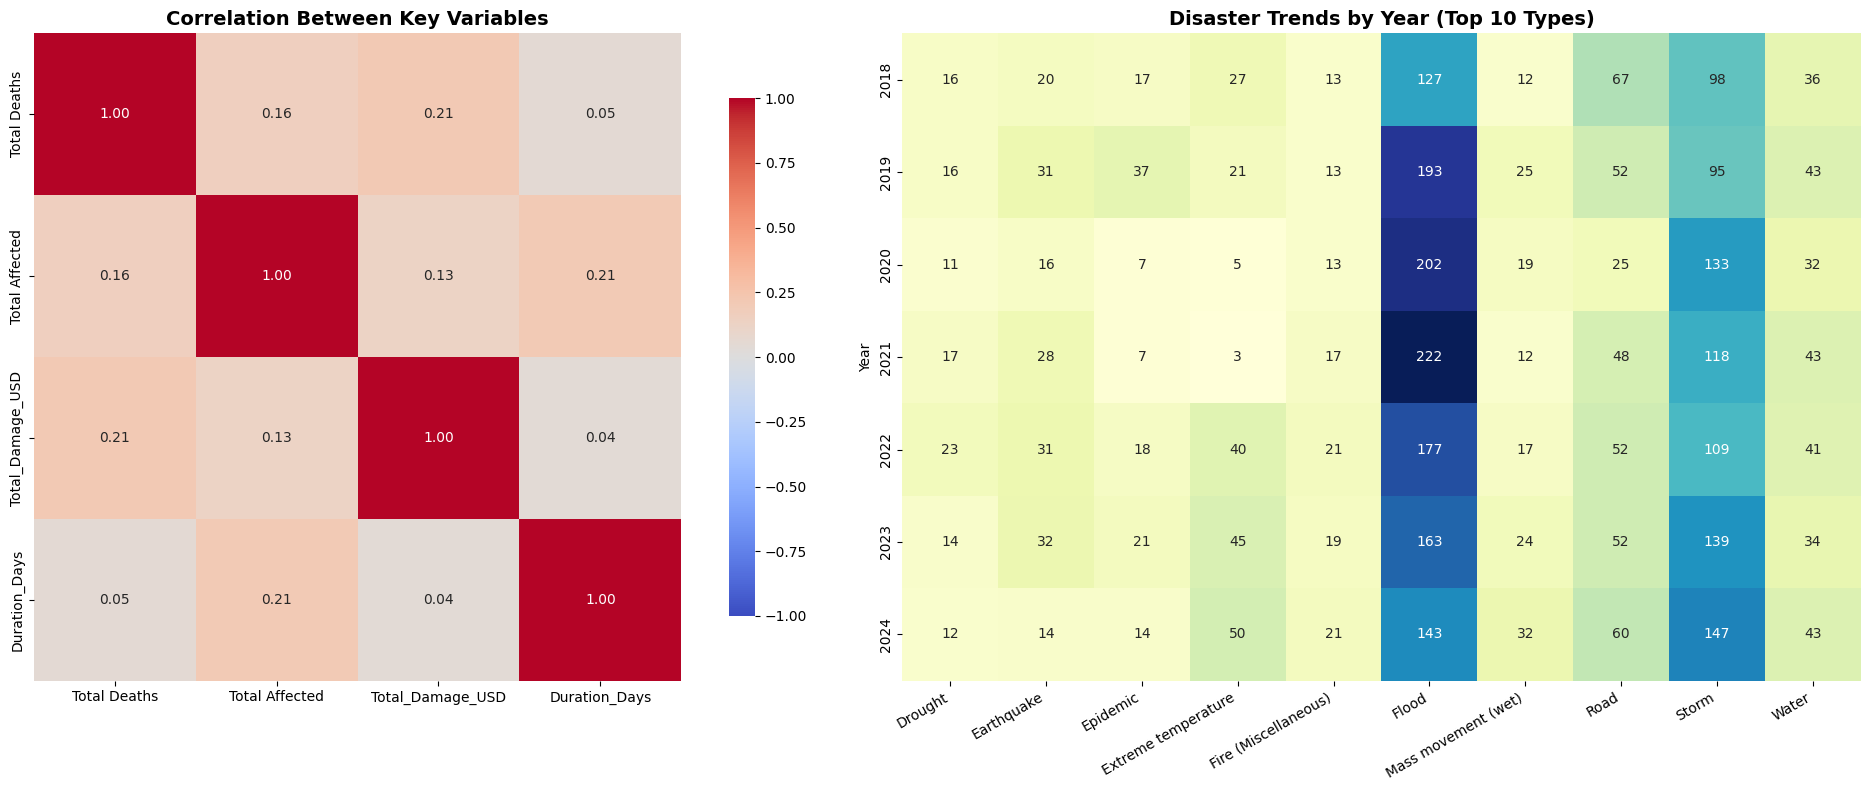

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. DATA PREPARATION ---
# Assuming df is already loaded. If not:
# df = pd.read_csv('public_emdat_custom_request_2018-2024.xlsx - EM-DAT Data.csv')

# Cleaning and transformations
if "Total Damage ('000 US$)" in df.columns:
    df.rename(columns={"Total Damage ('000 US$)": 'Total_Damage_USD'}, inplace=True)

df['Total Deaths'] = df['Total Deaths'].fillna(0)
df['Total Affected'] = df['Total Affected'].fillna(0)

# Date construction and duration calculation
df['Start Month'] = df['Start Month'].fillna(1).astype(int)
df['Start Day'] = df['Start Day'].fillna(1).astype(int)
df['End Month'] = df['End Month'].fillna(1).astype(int)
df['End Day'] = df['End Day'].fillna(1).astype(int)
df['Disaster_Date'] = pd.to_datetime(
    dict(year=df['Start Year'], month=df['Start Month'], day=df['Start Day']),
    errors='coerce'
)
df['End_Date'] = pd.to_datetime(
    dict(year=df['End Year'], month=df['End Month'], day=df['End Day']),
    errors='coerce'
)
df['Duration_Days'] = (df['End_Date'] - df['Disaster_Date']).dt.days
df['Duration_Days'] = df['Duration_Days'].fillna(1).clip(lower=1)

# --- 2. VISUALIZATION (Section 1) ---
# Create space for two side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# A) CORRELATION MATRIX (Left)
corr_cols = ['Total Deaths', 'Total Affected', 'Total_Damage_USD', 'Duration_Days']
corr_matrix = df[corr_cols].corr()

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    ax=axes[0],
    square=True,
    cbar_kws={"shrink": .8},
    vmin=-1,
    vmax=1
)
axes[0].set_title('Correlation Between Key Variables', fontsize=14, fontweight='bold')

# B) YEAR vs DISASTER TYPE TRENDS (Right)
# Keep only the top 10 most frequent disaster types
top_disasters = df['Disaster Type'].value_counts().nlargest(10).index
df_trend = df[df['Disaster Type'].isin(top_disasters)]
year_trend = pd.crosstab(df_trend['Start Year'], df_trend['Disaster Type'])

sns.heatmap(year_trend, cmap='YlGnBu', annot=True, fmt="d", ax=axes[1], cbar=False)
axes[1].set_title('Disaster Trends by Year (Top 10 Types)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Year')
axes[1].set_xlabel('')

# 👉 X-axis labels: rotate slightly for readability
axes[1].set_xticklabels(
    axes[1].get_xticklabels(),
    rotation=30,
    ha='right'
)

plt.tight_layout()
plt.show()



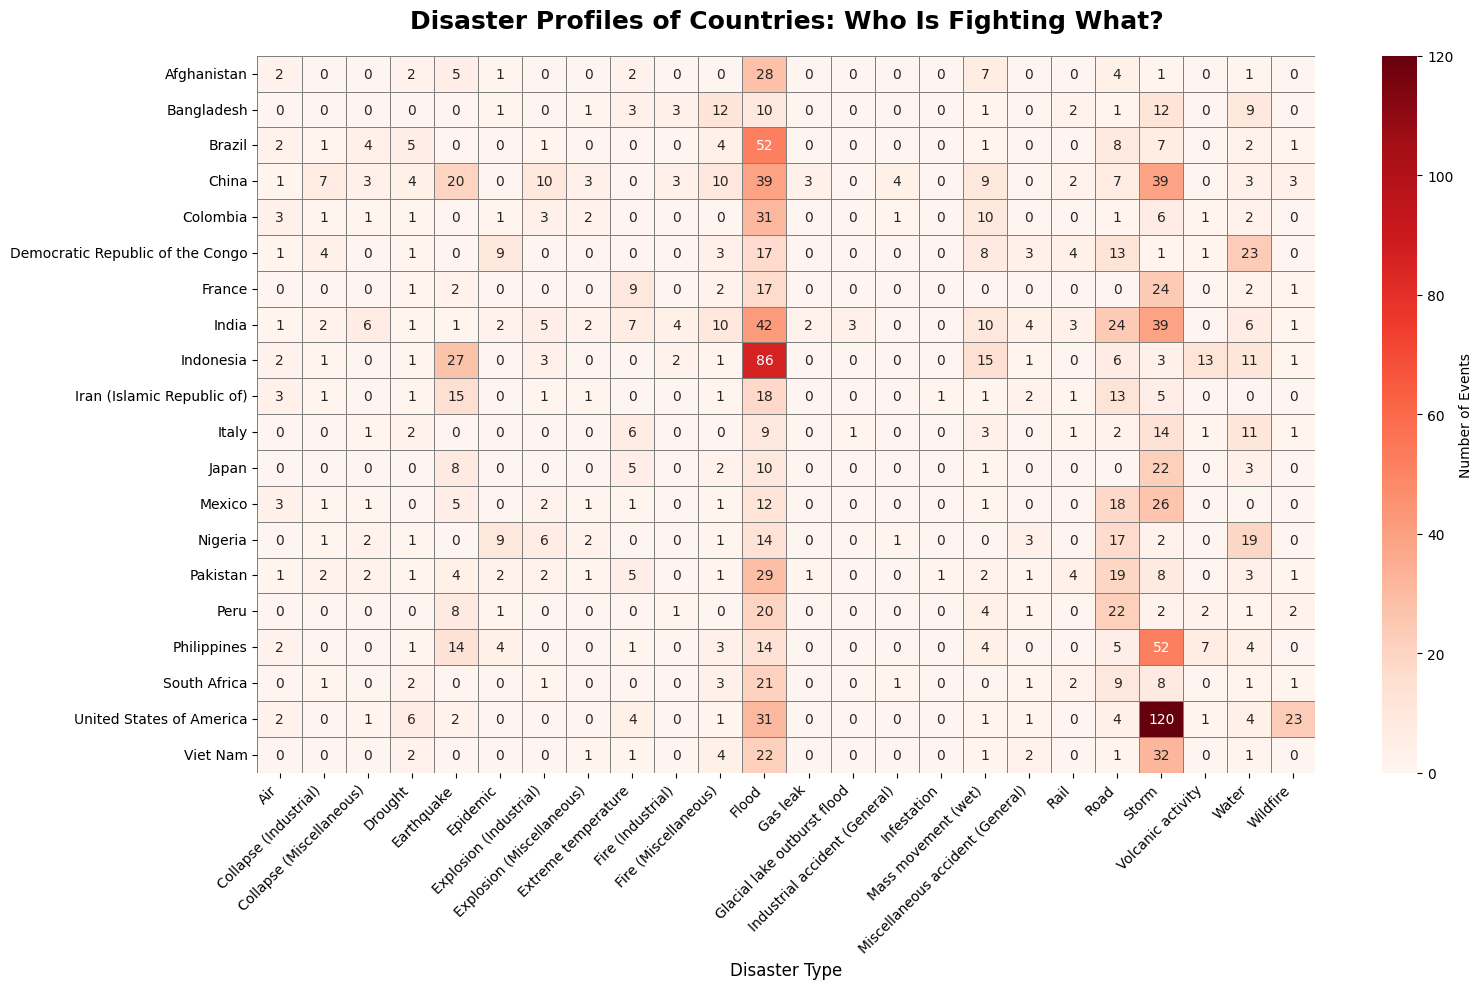

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- VISUALIZATION (Section 2: Country-Level Analysis) ---
plt.figure(figsize=(16, 10))  # Allocate a large plotting area

# Select the top 20 countries with the highest number of events
top_20_countries = df['Country'].value_counts().nlargest(20).index
df_country = df[df['Country'].isin(top_20_countries)]

# Create the matrix (Country x Disaster Type)
country_matrix = pd.crosstab(df_country['Country'], df_country['Disaster Type'])

# Draw the heatmap
sns.heatmap(
    country_matrix,
    cmap='Reds',
    annot=True,
    fmt="d",
    linewidths=.5,
    linecolor='gray',
    cbar_kws={"label": "Number of Events"}
)

# Titles and labels
plt.title(
    'Disaster Profiles of Countries: Who Is Fighting What?',
    fontsize=18,
    fontweight='bold',
    pad=20
)
plt.xlabel('Disaster Type', fontsize=12)
plt.ylabel('')
plt.xticks(rotation=45, ha='right')  # Rotate disaster names for readability

plt.tight_layout()
plt.show()


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. DATA INITIALIZATION & FEATURE ENGINEERING
# ==========================================
# Objective: Load data and engineer new features (Duration) for correlation analysis.

# Dosya Yolları (Kendi bilgisayarındaki yollara göre düzenle)
CLEAN_PATH = '../data/cleaned_data_final.csv'
RAW_PATH = '../data/public_emdat_custom_request_2018-2024.xlsx' 

# 1. Temiz Veriyi Yükle (Genel Analizler İçin)
df = pd.read_csv(CLEAN_PATH)

# 2. Ham Veriyi Yükle (Detaylı Korelasyon İçin)
try:
    df_raw = pd.read_csv(RAW_PATH)
    print("Raw Data Loaded Successfully.")
except:
    try:
        df_raw = pd.read_excel('../data/public_emdat_custom_request_2018-2024.xlsx')
        print("Raw Excel Loaded.")
    except:
        print("Error: Raw data not found!")

# 3. Yeni Özellik Türetme: 'Duration' (Süre)
# Proposal'daki "response metrics" yerine "Süre" analizi yapıyoruz.
# Start ve End sütunlarını datetime'a çevirip fark alıyoruz.
def create_date(row, type_):
    try:
        return pd.to_datetime(f"{int(row[f'{type_} Year'])}-{int(row[f'{type_} Month'])}-{int(row[f'{type_} Day'])}")
    except:
        return pd.NaT

if 'df_raw' in locals():
    df_raw['Start Date'] = df_raw.apply(lambda row: create_date(row, 'Start'), axis=1)
    df_raw['End Date'] = df_raw.apply(lambda row: create_date(row, 'End'), axis=1)
    df_raw['Duration Days'] = (df_raw['End Date'] - df_raw['Start Date']).dt.days.fillna(1) # En az 1 gün
    # Negatif veya 0 süreli hataları 1 yap
    df_raw['Duration Days'] = df_raw['Duration Days'].apply(lambda x: 1 if x <= 0 else x)

# Tasarım Ayarları
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.dpi'] = 150
sns.set_style("whitegrid")

print("Setup & Feature Engineering Complete.")

Raw Excel Loaded.
Setup & Feature Engineering Complete.


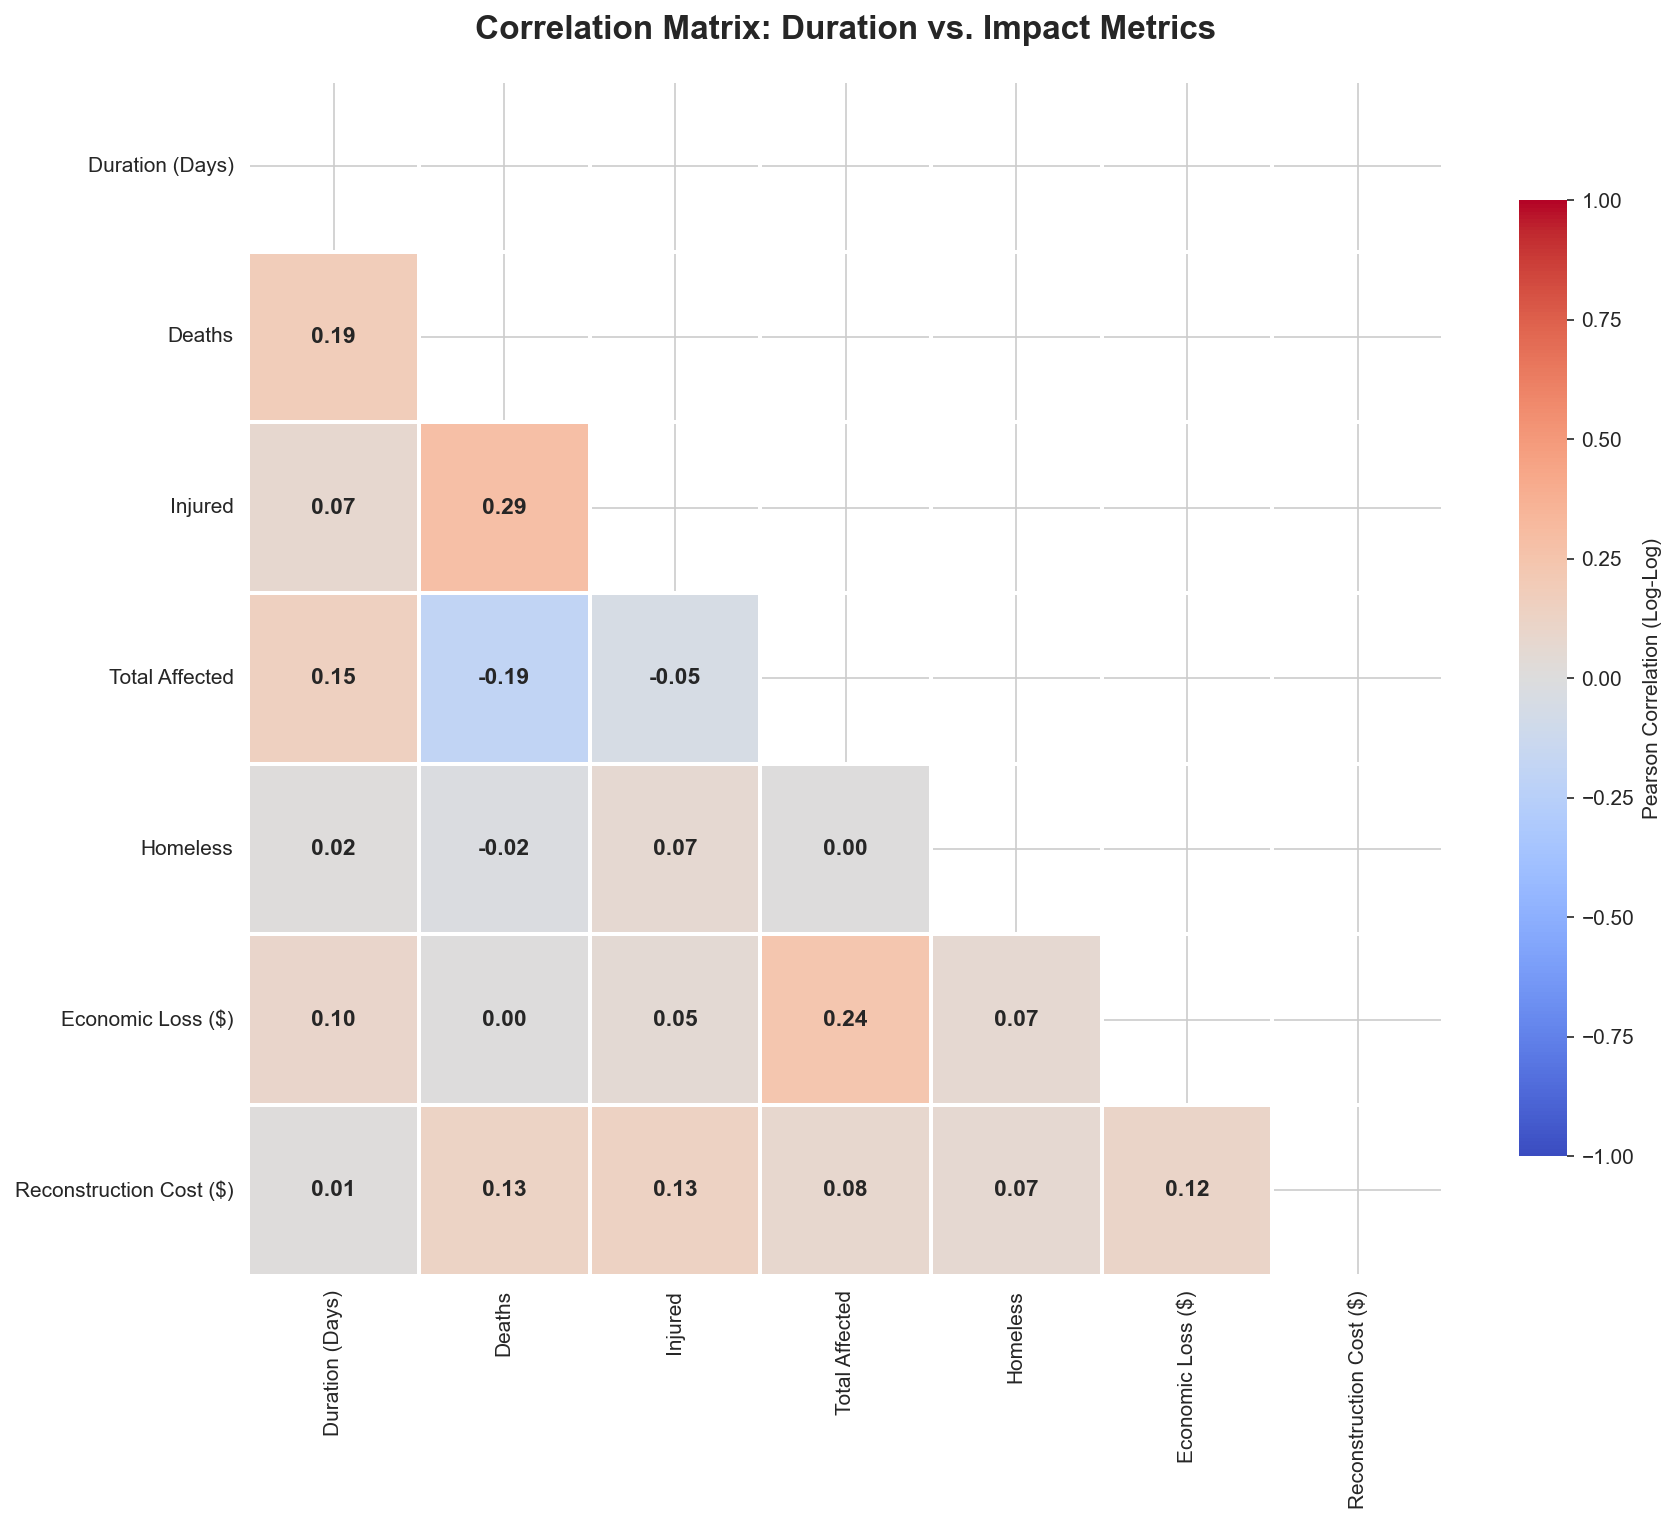

In [10]:
# ==========================================
# 2. MULTI-DIMENSIONAL CORRELATION MATRIX
# ==========================================
# Analytical Goal: Analyze relationships between Duration, Human Impact, and Economic Loss.
# Method: Log-Log Correlation to handle extreme outliers (Power Law distribution).

# 1. Analiz Edilecek Sütunları Seç
cols_map = {
    'Duration Days': 'Duration (Days)',
    'Total Deaths': 'Deaths',
    'No. Injured': 'Injured',
    'No. Affected': 'Total Affected',
    'No. Homeless': 'Homeless',
    "Total Damage, Adjusted ('000 US$)": 'Economic Loss ($)',
    "Reconstruction Costs, Adjusted ('000 US$)": 'Reconstruction Cost ($)'
}

# Mevcut sütunları al
available_cols = [c for c in cols_map.keys() if c in df_raw.columns]
corr_df = df_raw[available_cols].rename(columns=cols_map)

# 2. Eksik Verileri Doldur
corr_df = corr_df.fillna(0)

# 3. Logaritmik Dönüşüm (Önemli!)
# +1 ekliyoruz ki log(0) hatası olmasın
log_corr_df = np.log1p(corr_df)

# 4. Korelasyon Matrisini Hesapla
corr_matrix = log_corr_df.corr()

# 5. Görselleştirme
fig, ax = plt.subplots(figsize=(12, 10))

# Üst üçgeni maskele (Simetrik olduğu için)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True, fmt=".2f", 
            cmap='coolwarm', # Kırmızı (+), Mavi (-) ilişki
            square=True, 
            linewidths=1, linecolor='white',
            cbar_kws={"shrink": 0.8, "label": "Pearson Correlation (Log-Log)"},
            annot_kws={"size": 11, "weight": "bold"},
            vmin=-1, vmax=1)

ax.set_title("Correlation Matrix: Duration vs. Impact Metrics", fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

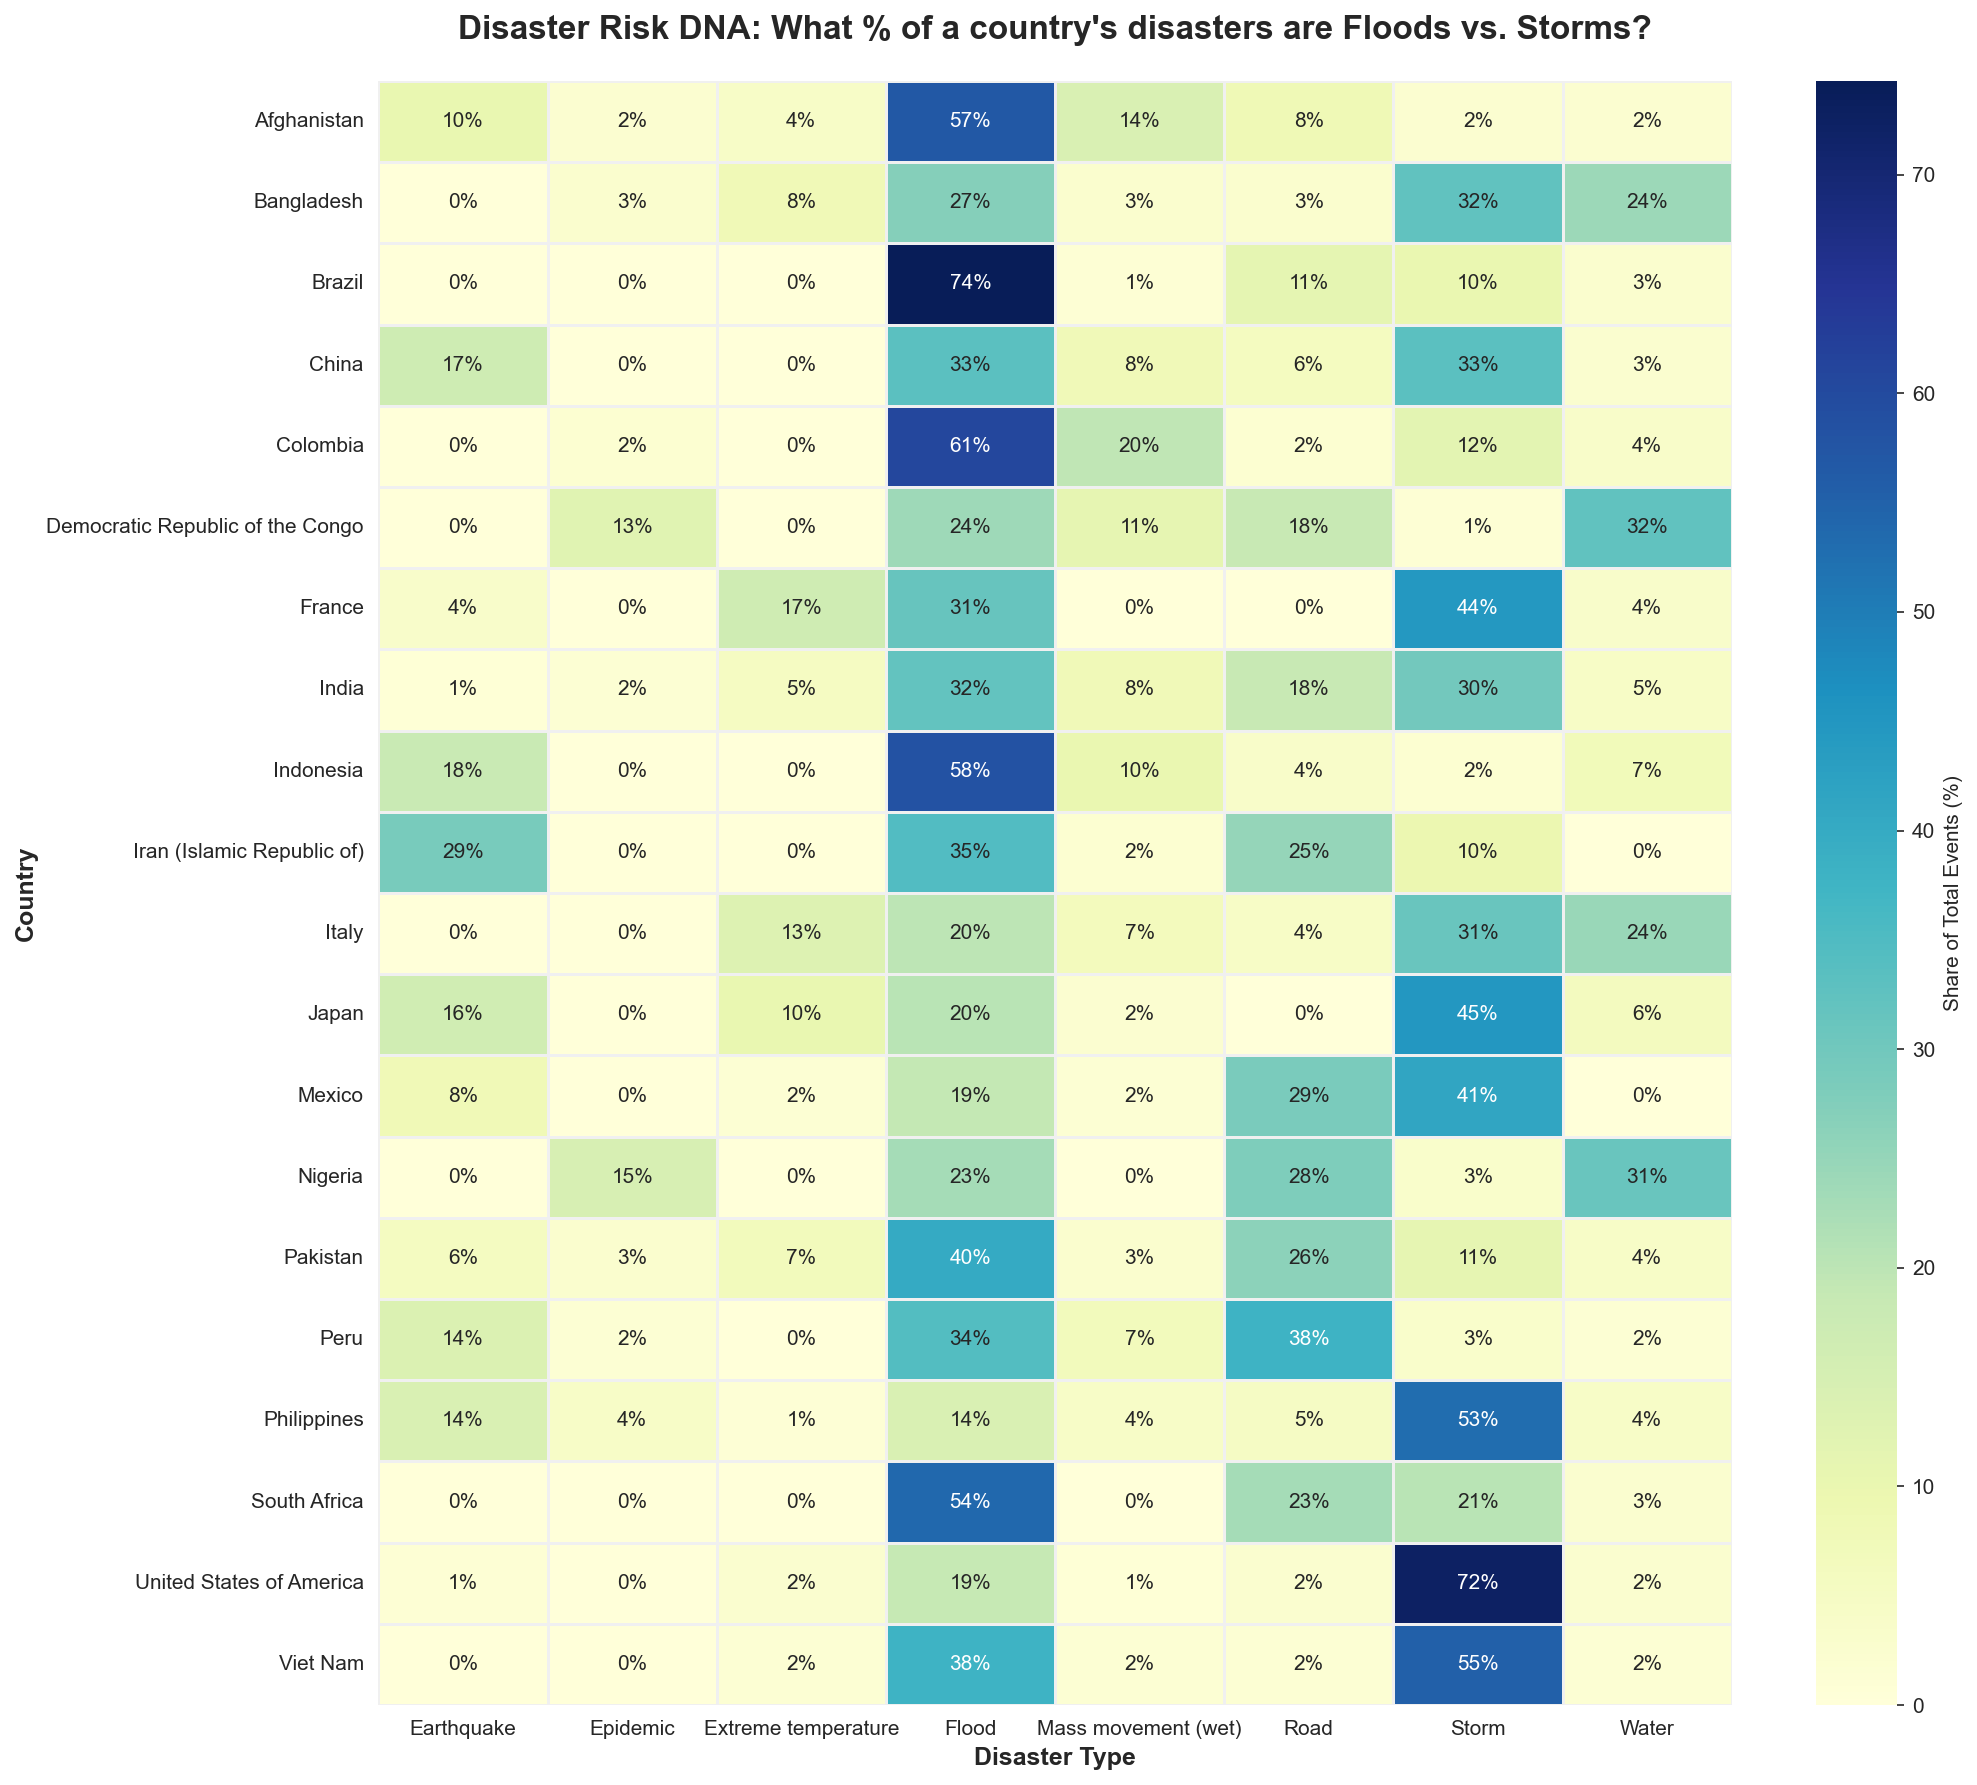

In [11]:
# ==========================================
# 3. COUNTRY RISK PROFILING (Percentage Share Matrix)
# ==========================================
# Analytical Goal: Identify the dominant disaster type for key countries based on PROPORTION, not just count.
# Solves "Flood Dominance" by showing the relative share of each disaster per country.

# 1. Filtreleme (Top 20 Ülke, Top 8 Tür)
# Sütun isimlerini standartlaştır
df.columns = df.columns.str.lower().str.strip()

top_countries = df['country'].value_counts().head(20).index
top_types = df['disaster_type'].value_counts().head(8).index 

df_matrix = df[df['country'].isin(top_countries) & df['disaster_type'].isin(top_types)]

# 2. Pivot Tablo (Ham Sayılar)
raw_matrix = df_matrix.groupby(['country', 'disaster_type']).size().unstack(fill_value=0)

# 3. YÜZDE HESAPLAMA (Satır Bazlı)
# Her ülkenin toplam afet sayısına bölüyoruz
pct_matrix = raw_matrix.div(raw_matrix.sum(axis=1), axis=0) * 100

# 4. Görselleştirme
fig, ax = plt.subplots(figsize=(14, 12))

sns.heatmap(pct_matrix, 
            annot=True, # Hücre içine YÜZDEYİ yaz
            fmt=".0f",  # Ondalık yok
            cmap='YlGnBu', # Sarı -> Yeşil -> Mavi (Yoğunluk)
            linewidths=0.5, linecolor='#f0f0f0',
            cbar_kws={'label': 'Share of Total Events (%)'})

# Yüzde işareti ekle
for t in ax.texts: t.set_text(t.get_text() + "%")

ax.set_title("Disaster Risk DNA: What % of a country's disasters are Floods vs. Storms?", fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel("Disaster Type", fontsize=12, fontweight='bold')
ax.set_ylabel("Country", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

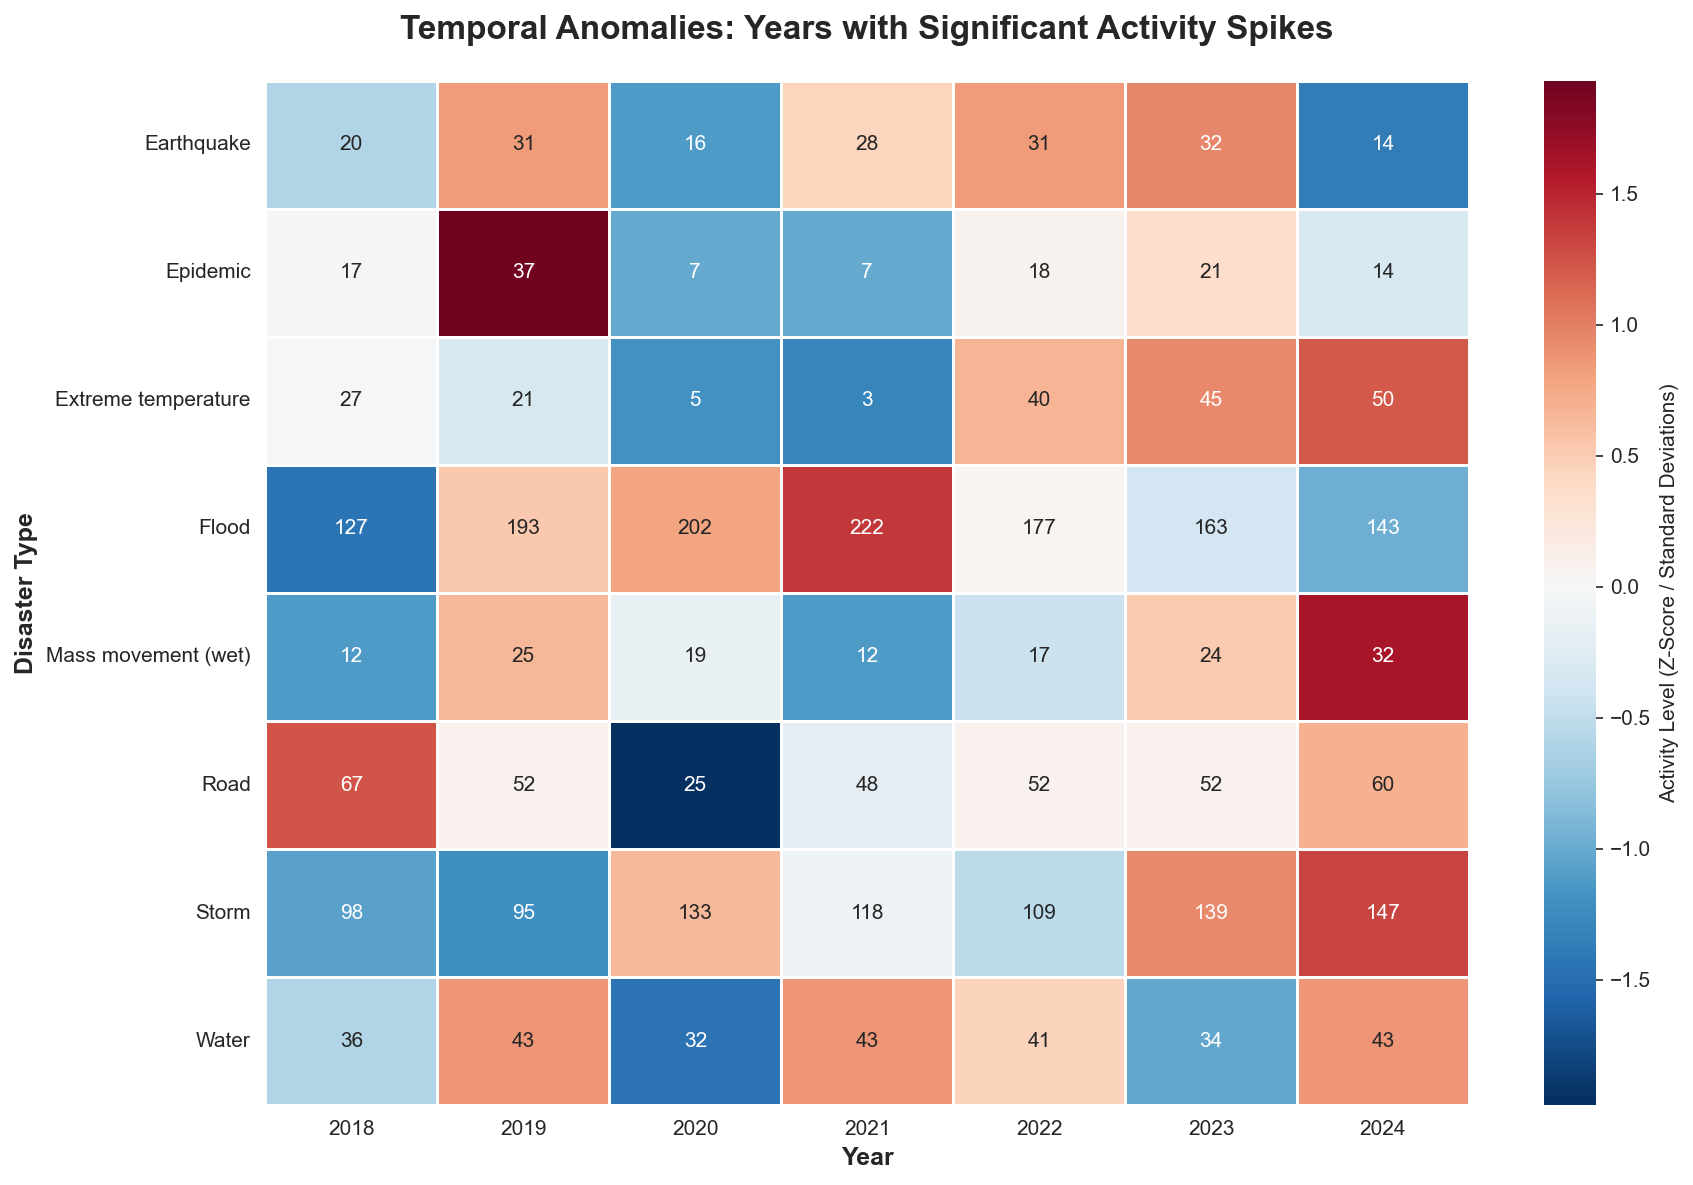

In [12]:
# ==========================================
# 4. TEMPORAL ANOMALY DETECTION (Z-Score Trend Matrix)
# ==========================================
# Analytical Goal: Identify years with statistically significant spikes in activity.
# Method: Z-Score Standardization per disaster type.
# Result: Highlights "Peak Years" for every disaster type equally.

# 1. Pivot Tablo (Yıl x Tür)
df_trend = df[df['disaster_type'].isin(top_types)]
year_type_matrix = df_trend.groupby(['disaster_type', 'year']).size().unstack(fill_value=0)

# 2. Z-SCORE HESAPLAMA (Satır Bazlı)
# (Değer - Ortalama) / Standart Sapma
# Bu işlem her satırı kendi içinde ölçekler. Sel'in 100'ü ile Depremin 10'u aynı "Şiddet" (Z-Score) olarak görünebilir.
z_score_matrix = year_type_matrix.apply(lambda x: (x - x.mean()) / x.std(), axis=1)

# 3. Görselleştirme
fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(z_score_matrix, 
            annot=year_type_matrix, # Annotasyon olarak GERÇEK SAYILARI göster (Context için)
            fmt="d", 
            cmap='RdBu_r', # Kırmızı = Yüksek (Anomali), Mavi = Düşük
            center=0, # Ortalama (Beyaz)
            linewidths=0.5, linecolor='white',
            cbar_kws={'label': 'Activity Level (Z-Score / Standard Deviations)'})

ax.set_title("Temporal Anomalies: Years with Significant Activity Spikes", fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel("Year", fontsize=12, fontweight='bold')
ax.set_ylabel("Disaster Type", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

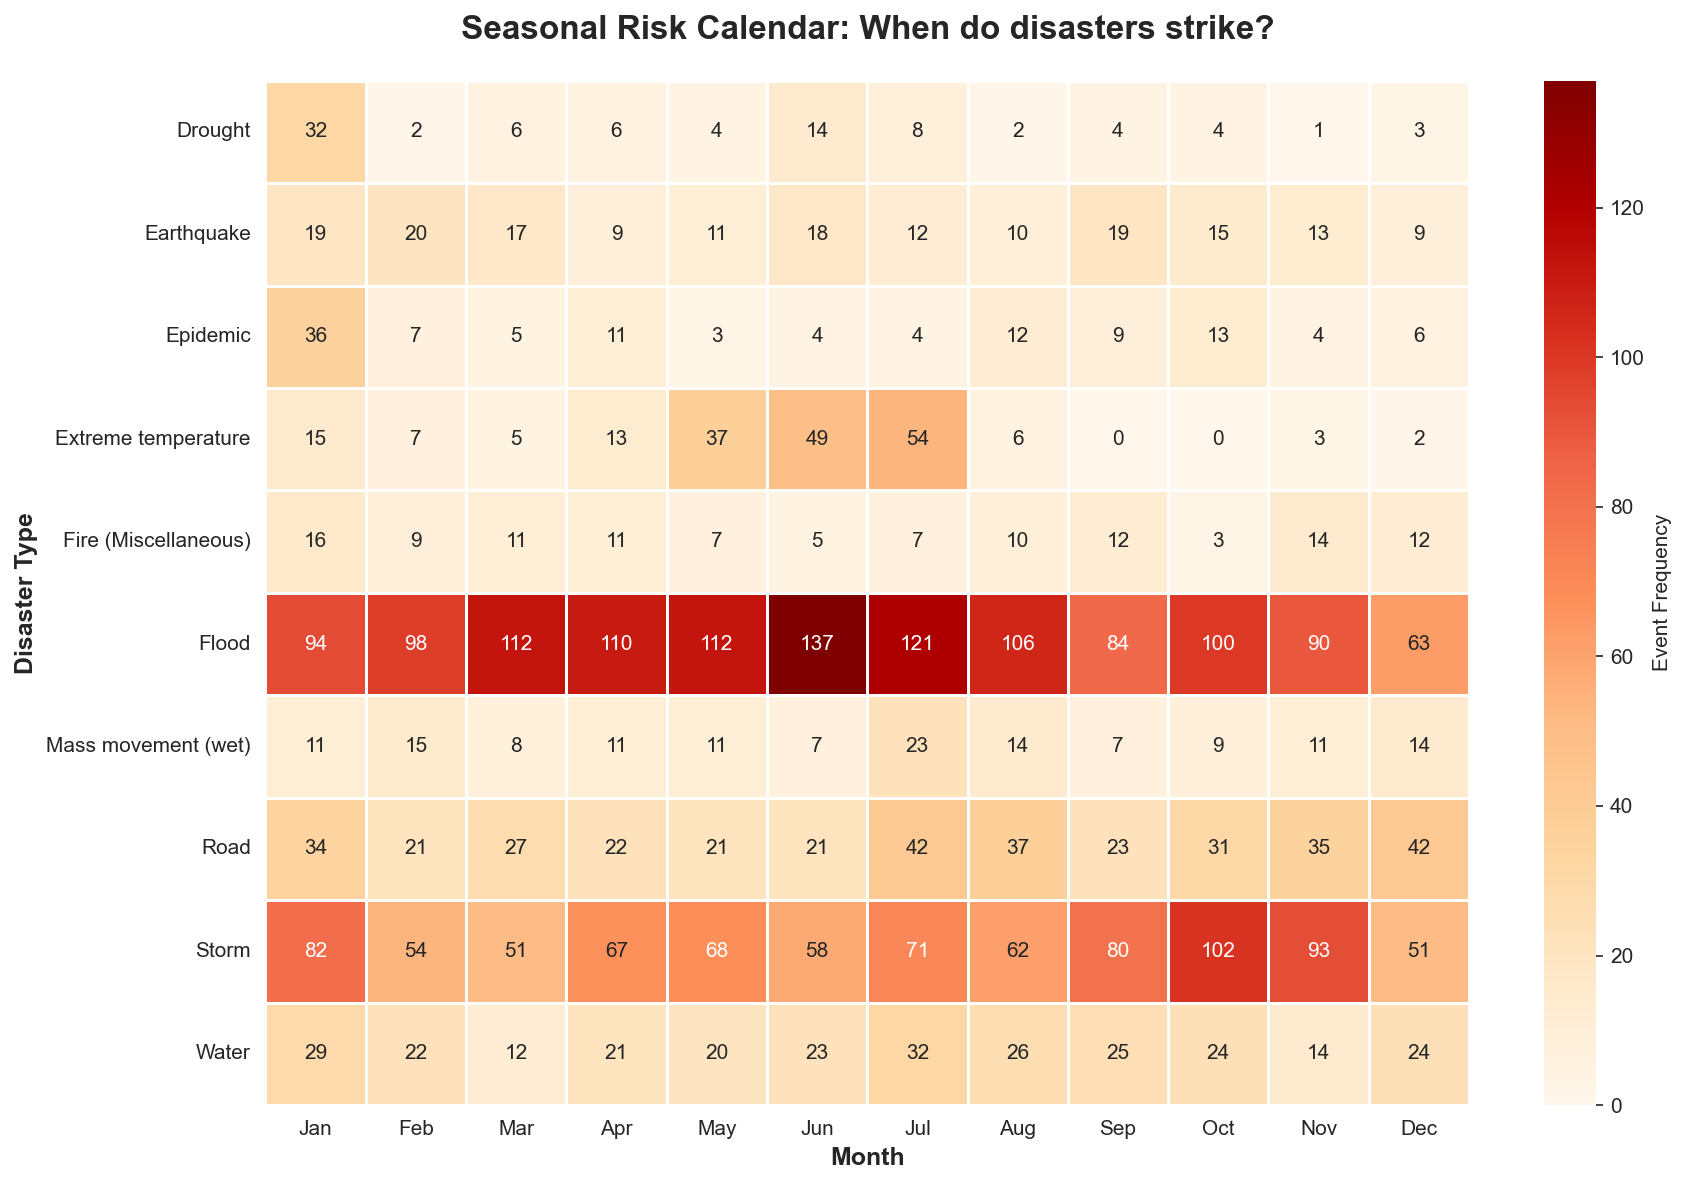

In [7]:
# ==========================================
# 5. SEASONAL RISK CALENDAR (Month x Type)
# ==========================================
# Analytical Goal: Visualize the seasonality of disasters to identify high-risk windows.

# 1. Prepare Data
df_season = df[df['month'] > 0]
df_season = df_season[df_season['disaster_type'].isin(top_types)]
month_type_matrix = df_season.groupby(['disaster_type', 'month']).size().unstack(fill_value=0)

# Format Labels
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_type_matrix.columns = month_labels

# 2. Visualization
fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(month_type_matrix, 
            annot=True, fmt="d", 
            cmap='OrRd', # Orange-Red
            linewidths=0.5, linecolor='white',
            cbar_kws={'label': 'Event Frequency'})

ax.set_title("Seasonal Risk Calendar: When do disasters strike?", fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel("Month", fontsize=12, fontweight='bold')
ax.set_ylabel("Disaster Type", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()